In [2]:
import pandas as pd

# Read the CSV files into pandas dataframes
qual_data = pd.read_csv('qualitative_data_msba.csv')
raw_ts = pd.read_csv('time_series_data_msba.csv')

# Select certain columns from the qualitative data
selected_columns = [
    "site_id_msba", "square_feet", "parking_spaces", "lottery",
    "bonfire_grill", "pizza", "ethanol_free", "hi_flow_lanes",
    "rv_lanes", "def", "rv_dumps"
]
select_qual = qual_data[selected_columns]

# Merge the time series data with the selected columns from qualitative data
merged_df = pd.merge(raw_ts, select_qual, how='left', on='site_id_msba')

# Convert character columns to categorical and rename the identifier column
# In Python, usually all non-numeric columns are considered as objects which can be equivalent to factors in R
merged_df = merged_df.rename(columns={'X': 'row_id'})
for col in merged_df.select_dtypes(include='object').columns:
    merged_df[col] = merged_df[col].astype('category')

# Display the first few rows of the merged dataframe
merged_df.head()


,Unnamed: 0,capital_projects.soft_opening_date,calendar.calendar_day_date,calendar.fiscal_week_id_for_year,calendar.day_of_week,calendar_information.holiday,calendar_information.type_of_day,daily_yoy_ndt.total_inside_sales,daily_yoy_ndt.total_food_service,diesel,...,square_feet,parking_spaces,lottery,bonfire_grill,pizza,ethanol_free,hi_flow_lanes,rv_lanes,def,rv_dumps
0,1,2022-06-14,2022-06-17,25,Friday,NONE,WEEKDAY,2168.2920,861.6930,722.7745,...,4630.0,45.0,Yes,No,No,Yes,Yes,Yes,Yes,No
1,2,2022-06-14,2022-06-22,25,Wednesday,NONE,WEEKDAY,2051.5635,808.0275,730.4850,...,4630.0,45.0,Yes,No,No,Yes,Yes,Yes,Yes,No
2,3,2022-06-14,2022-06-23,25,Thursday,NONE,WEEKDAY,2257.5000,966.4410,895.7970,...,4630.0,45.0,Yes,No,No,Yes,Yes,Yes,Yes,No
3,4,2022-06-14,2022-06-26,26,Sunday,NONE,WEEKEND,1520.5925,542.3250,584.2900,...,4630.0,45.0,Yes,No,No,Yes,Yes,Yes,Yes,No
4,5,2022-06-14,2022-06-27,26,Monday,NONE,WEEKDAY,1897.6930,771.4525,852.2605,...,4630.0,45.0,Yes,No,No,Yes,Yes,Yes,Yes,No


D:\Anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
D:\Anaconda\Lib\site-packages\seaborn\axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
D:\Anaconda\Lib\site-packages\seaborn\axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
D:\Anaconda\Lib\site-packages\seaborn\axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
D:\Anaconda\Lib\site-packages\seaborn\axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
D:\Anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figur

TypeError: unsupported operand type(s) for *: 'Timestamp' and 'float'

<Figure size 1500x1000 with 0 Axes>

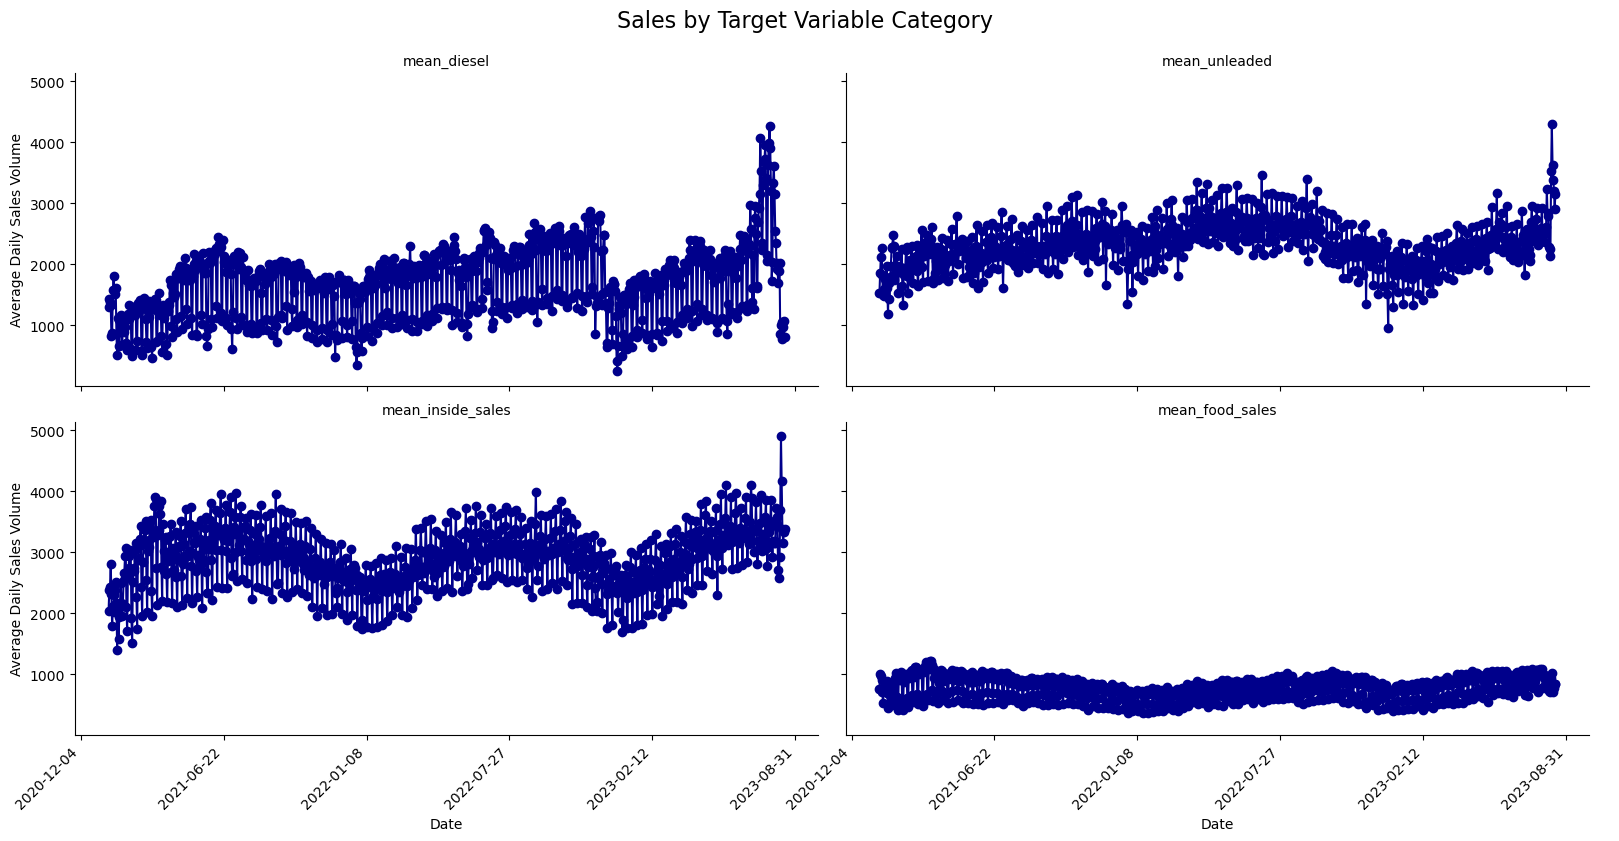

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

# Select specific columns and rename them
mean_subset = raw_ts[['calendar.calendar_day_date',
                                'diesel', 'unleaded',
                                'daily_yoy_ndt.total_inside_sales',
                                'daily_yoy_ndt.total_food_service']].copy()

mean_subset.rename(columns={
    'calendar.calendar_day_date': 'date',
    'daily_yoy_ndt.total_inside_sales': 'inside_sales',
    'daily_yoy_ndt.total_food_service': 'food_sales'
}, inplace=True)

# Convert 'date' column to datetime
mean_subset['date'] = pd.to_datetime(mean_subset['date'])

# Group by date and calculate mean for the selected columns
mean_subset['mean_diesel'] = mean_subset.groupby('date')['diesel'].transform('mean')
mean_subset['mean_unleaded'] = mean_subset.groupby('date')['unleaded'].transform('mean')
mean_subset['mean_inside_sales'] = mean_subset.groupby('date')['inside_sales'].transform('mean')
mean_subset['mean_food_sales'] = mean_subset.groupby('date')['food_sales'].transform('mean')

# Select unique rows
mean_subset = mean_subset[['date', 'mean_diesel', 'mean_unleaded', 'mean_inside_sales', 'mean_food_sales']].drop_duplicates()

# Reshape the data from wide to long format
lng_avg = pd.melt(mean_subset, id_vars="date", var_name="product_type", value_name="average_sales")

# Faceted line plot by category
register_matplotlib_converters()  # Register pandas converters with matplotlib

# Set the size of the plot
plt.figure(figsize=(15, 10))

# Create faceted plot using seaborn
g = sns.FacetGrid(lng_avg, col="product_type", col_wrap=2, height=4, aspect=2)
g = g.map(plt.scatter, "date", "average_sales", color="darkblue").add_legend()
g = g.map(sns.lineplot, "date", "average_sales", color="darkblue", ci=None).add_legend()

# Adjust the axis and labels
for ax in g.axes:
    ax.xaxis.set_major_locator(plt.MaxNLocator(6))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

# Set titles and labels
g.set_titles("{col_name}")
g.set_axis_labels("Date", "Average Daily Sales Volume")
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Sales by Target Variable Category', fontsize=16)

# Draw a LOESS smoothed line
for ax in g.axes:
    sns.regplot(x='date', y='average_sales', data=lng_avg[lng_avg['product_type'] == ax.get_title()],
                scatter=False, ax=ax, lowess=True, color="red")

plt.show()


In [4]:
import numpy as np

# Step 1: Read the CSV file with date parsing
time_series_data = pd.read_csv('time_series_data_msba.csv'
    ,
    parse_dates=['capital_projects.soft_opening_date', 'calendar.calendar_day_date']
)

# Step 2: Calculate the number of days since the store opened
time_series_data['Days_Since_Open'] = (
    time_series_data['calendar.calendar_day_date'] - time_series_data['capital_projects.soft_opening_date']
).dt.days

# Rename the identifier column and sort by 'site_id_msba' and 'calendar.calendar_day_date'
time_series_data.rename(columns={'...1': 'row_id'}, inplace=True)
time_series_data.sort_values(by=['site_id_msba', 'calendar.calendar_day_date'], inplace=True)

# Step 3: Define the major holidays DataFrame
major_holidays_dates = [
    "2021-01-01", "2021-01-18", "2021-04-04", "2021-05-31", "2021-07-04", "2021-09-06",
    "2021-10-11", "2021-11-11", "2021-11-25", "2021-12-24", "2021-12-25", "2021-12-31",
    "2022-01-01", "2022-01-17", "2022-04-17", "2022-05-30", "2022-07-04", "2022-09-05",
    "2022-10-10", "2022-11-11", "2022-11-24", "2022-12-24", "2022-12-25", "2022-12-31"
]
major_holidays_names = [
    "New Year's Day", "Martin Luther King Jr. Day", "Easter Sunday", "Memorial Day", "Independence Day",
    "Labor Day", "Columbus Day", "Veterans Day", "Thanksgiving Day", "Christmas Eve", "Christmas Day",
    "New Year's Eve", "New Year's Day", "Martin Luther King Jr. Day", "Easter Sunday", "Memorial Day",
    "Independence Day", "Labor Day", "Columbus Day", "Veterans Day", "Thanksgiving Day", "Christmas Eve",
    "Christmas Day", "New Year's Eve"
]
major_holidays = pd.DataFrame({
    'calendar.calendar_day_date': pd.to_datetime(major_holidays_dates),
    'Major_Holiday': major_holidays_names
})

# Step 4: Merge the original DataFrame with the major holidays DataFrame
ts_w_holidays = pd.merge(
    time_series_data,
    major_holidays,
    how='left',
    on='calendar.calendar_day_date'
)

# Step 5: Create an indicator for whether the day is a holiday
ts_w_holidays['General_Holiday'] = np.where(ts_w_holidays['calendar_information.holiday'] == "NONE", 0, 1)

# Display the first few rows of the dataframe with holidays
ts_w_holidays.head()


,Unnamed: 0,capital_projects.soft_opening_date,calendar.calendar_day_date,calendar.fiscal_week_id_for_year,calendar.day_of_week,calendar_information.holiday,calendar_information.type_of_day,daily_yoy_ndt.total_inside_sales,daily_yoy_ndt.total_food_service,diesel,unleaded,site_id_msba,Days_Since_Open,Major_Holiday,General_Holiday
0,13814,2021-01-12,2021-01-12,2,Tuesday,NONE,WEEKDAY,2036.2685,762.8530,1424.1850,1522.0030,21560,0,NaN,0
1,13815,2021-01-12,2021-01-13,2,Wednesday,NONE,WEEKDAY,2379.8880,1003.7930,1303.8445,1853.7715,21560,1,NaN,0
2,13816,2021-01-12,2021-01-14,2,Thursday,NONE,WEEKDAY,2435.8600,974.2250,1375.6785,2122.4070,21560,2,NaN,0
3,13726,2021-01-12,2021-01-15,3,Friday,NONE,WEEKDAY,2805.9780,911.0115,1334.9175,2267.9930,21560,3,NaN,0
4,13817,2021-01-12,2021-01-16,3,Saturday,NONE,WEEKEND,2314.7635,715.7535,831.1625,1819.6395,21560,4,NaN,0


In [5]:
# Step 1: Group by 'calendar.day_of_week' and calculate averages
dow_summary = ts_w_holidays.groupby('calendar.day_of_week').agg(
    Avg_inside_sales=('daily_yoy_ndt.total_inside_sales', 'mean'),
    Avg_food_service=('daily_yoy_ndt.total_food_service', 'mean'),
    Avg_diesel_sales=('diesel', 'mean'),
    Avg_unleaded_sales=('unleaded', 'mean')
).reset_index()

# Create a styled HTML table from the DataFrame using the method that should be available in this environment
html_table = dow_summary.style.set_properties(**{'width': '100%', 'text-align': 'left'})

# Display the HTML table directly in the Jupyter Notebook (for demonstration purposes)
from IPython.display import display, HTML

# Display the HTML table directly in the Jupyter Notebook (for demonstration purposes)
html_table_html = html_table._repr_html_()
display(HTML(html_table_html))

# The HTML content is in 'html_table_html', which can be used in an HTML file or displayed in a browser
html_table_html  # this contains the HTML string of the table


,calendar.day_of_week,Avg_inside_sales,Avg_food_service,Avg_diesel_sales,Avg_unleaded_sales
0,Friday,3366.582282,882.491871,1845.983033,2794.113315
1,Monday,2780.556207,777.692956,1894.728744,2383.800690
2,Saturday,2756.193378,640.616270,1147.532033,2363.678907
3,Sunday,2247.810004,509.612523,1009.676778,2033.416496
4,Thursday,3066.268194,867.351256,1986.431140,2471.164486
5,Tuesday,2802.265570,806.664158,1987.379094,2294.119326
6,Wednesday,2905.310778,832.643233,2034.600464,2336.505549


'<style type="text/css">\n#T_ffc0c_row0_col0, #T_ffc0c_row0_col1, #T_ffc0c_row0_col2, #T_ffc0c_row0_col3, #T_ffc0c_row0_col4, #T_ffc0c_row1_col0, #T_ffc0c_row1_col1, #T_ffc0c_row1_col2, #T_ffc0c_row1_col3, #T_ffc0c_row1_col4, #T_ffc0c_row2_col0, #T_ffc0c_row2_col1, #T_ffc0c_row2_col2, #T_ffc0c_row2_col3, #T_ffc0c_row2_col4, #T_ffc0c_row3_col0, #T_ffc0c_row3_col1, #T_ffc0c_row3_col2, #T_ffc0c_row3_col3, #T_ffc0c_row3_col4, #T_ffc0c_row4_col0, #T_ffc0c_row4_col1, #T_ffc0c_row4_col2, #T_ffc0c_row4_col3, #T_ffc0c_row4_col4, #T_ffc0c_row5_col0, #T_ffc0c_row5_col1, #T_ffc0c_row5_col2, #T_ffc0c_row5_col3, #T_ffc0c_row5_col4, #T_ffc0c_row6_col0, #T_ffc0c_row6_col1, #T_ffc0c_row6_col2, #T_ffc0c_row6_col3, #T_ffc0c_row6_col4 {\n  width: 100%;\n  text-align: left;\n}\n</style>\n<table id="T_ffc0c">\n  <thead>\n    <tr>\n      <th class="blank level0" >&nbsp;</th>\n      <th id="T_ffc0c_level0_col0" class="col_heading level0 col0" >calendar.day_of_week</th>\n      <th id="T_ffc0c_level0_col1" clas

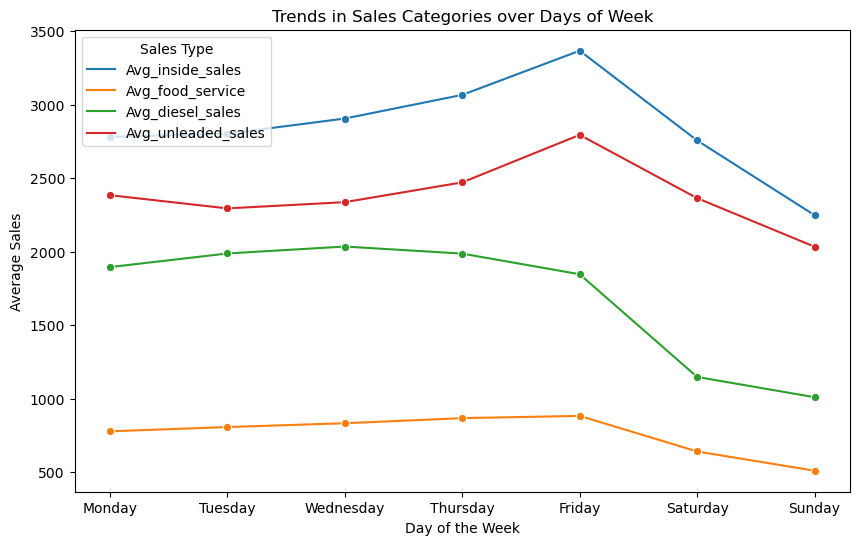

In [6]:
# Step 1: Reshape the DataFrame from wide to long format
data_long = pd.melt(dow_summary, id_vars=['calendar.day_of_week'], var_name='Sales_Type', value_name='Average_Sales')

# Step 2: Set a custom order for the days of the week
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
# Make sure the 'calendar.day_of_week' column is categorical with the specified order
data_long['calendar.day_of_week'] = pd.Categorical(data_long['calendar.day_of_week'], categories=day_order, ordered=True)

# Step 3: Create a line chart
plt.figure(figsize=(10, 6))
sns.lineplot(data=data_long, x='calendar.day_of_week', y='Average_Sales', hue='Sales_Type', marker='o')

# Customize the plot
plt.title('Trends in Sales Categories over Days of Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Sales')
plt.legend(title='Sales Type', loc='upper left')

# Show the plot
plt.show()


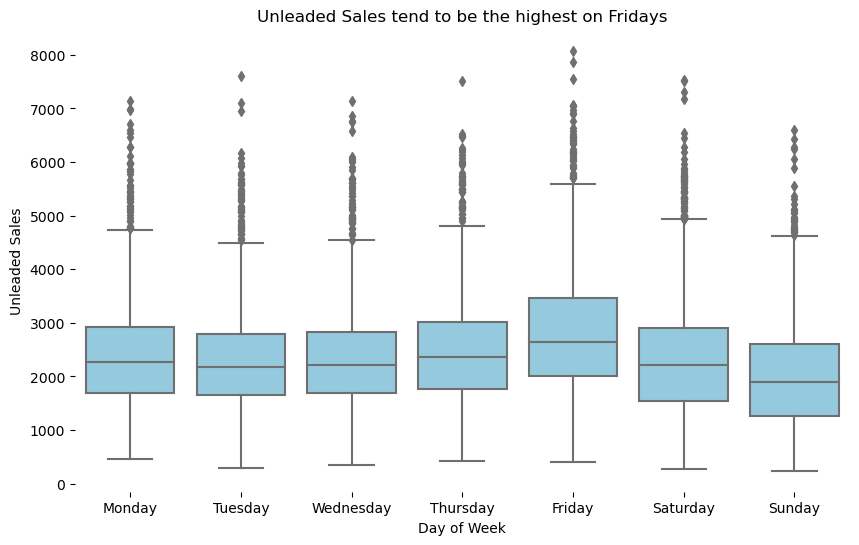

In [7]:
# Reorder the 'calendar.day_of_week' column in the ts_w_holidays DataFrame as done previously
ts_w_holidays['calendar.day_of_week'] = pd.Categorical(
    ts_w_holidays['calendar.day_of_week'],
    categories=day_order,
    ordered=True
)

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=ts_w_holidays, x='calendar.day_of_week', y='unleaded', color='skyblue')

# Customize the plot
plt.title('Unleaded Sales tend to be the highest on Fridays')
plt.xlabel('Day of Week')
plt.ylabel('Unleaded Sales')

# Hide gridlines
sns.despine(bottom=True, left=True)

# Print the boxplot
plt.show()


D:\Anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1600x1000 with 0 Axes>

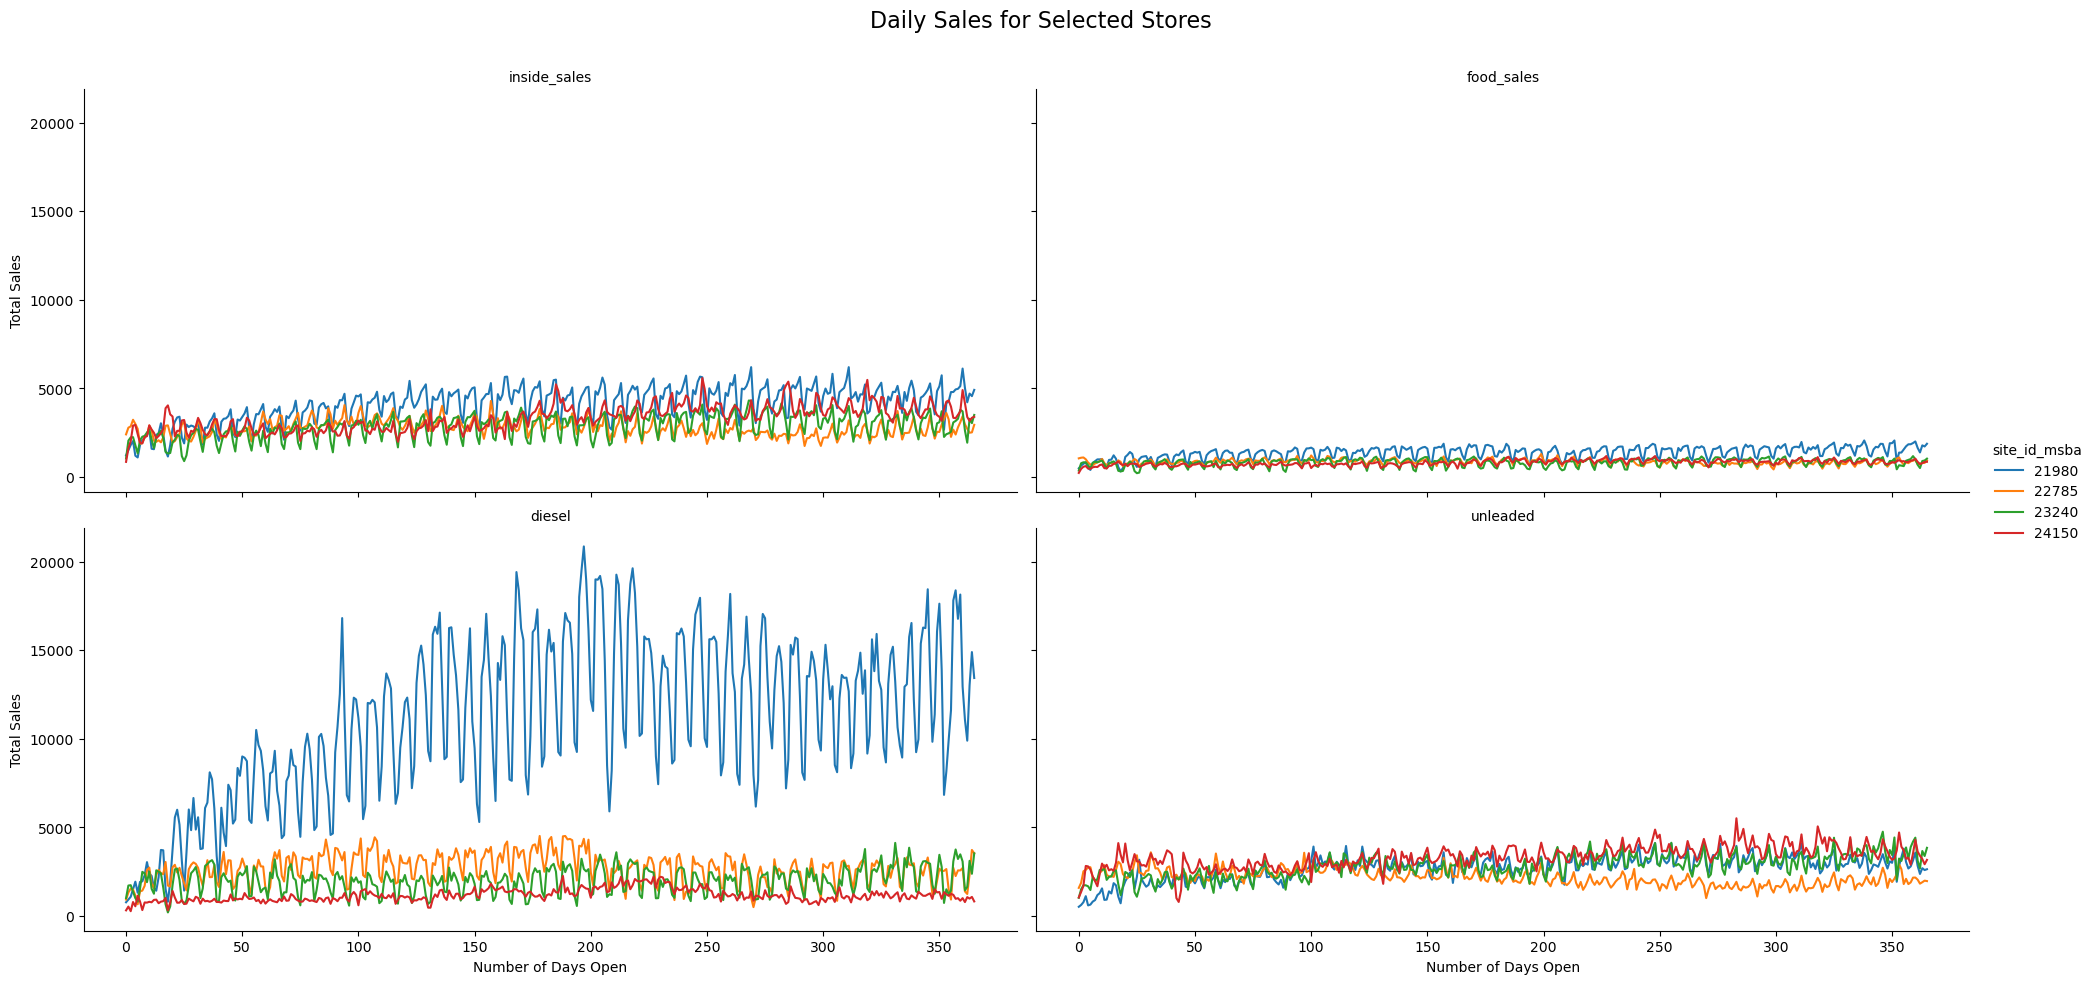

In [8]:
# Step 1: Filter the data to include only the selected stores
selected_stores = [21980, 23240, 24150, 22785]
stores_of_interest = ts_w_holidays[ts_w_holidays['site_id_msba'].isin(selected_stores)]

# Step 2: Select and rename specific columns
soi_subset = stores_of_interest[['Days_Since_Open', 'site_id_msba', 'daily_yoy_ndt.total_inside_sales', 'daily_yoy_ndt.total_food_service', 'diesel', 'unleaded']].copy()
soi_subset.rename(columns={
    'daily_yoy_ndt.total_inside_sales': 'inside_sales',
    'daily_yoy_ndt.total_food_service': 'food_sales'
}, inplace=True)

# Step 3: Reshape the data from wide to long format
soi_long = pd.melt(soi_subset, id_vars=['Days_Since_Open', 'site_id_msba'], var_name='product_type', value_name='average_sales')

# Step 4: Create a faceted line plot
plt.figure(figsize=(16, 10))

# Convert 'site_id_msba' to a categorical type for proper coloring and legend handling
soi_long['site_id_msba'] = soi_long['site_id_msba'].astype('category')

# Create the plot
g = sns.FacetGrid(soi_long, col="product_type", hue="site_id_msba", col_wrap=2, height=5, aspect=2)
g = g.map(sns.lineplot, "Days_Since_Open", "average_sales").add_legend()

# Customize the plot
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Number of Days Open", "Total Sales")
g.fig.subplots_adjust(top=0.9)  # adjust the Figure in g
g.fig.suptitle('Daily Sales for Selected Stores', fontsize=16)

plt.show()


In [9]:
# Step 1: Select and rename specific columns to focus on store-level data
stores_df = ts_w_holidays[['site_id_msba', 'diesel', 'unleaded', 'daily_yoy_ndt.total_inside_sales', 'daily_yoy_ndt.total_food_service']].copy()
stores_df.rename(columns={
    'site_id_msba': 'site_id',
    'daily_yoy_ndt.total_inside_sales': 'inside_sales',
    'daily_yoy_ndt.total_food_service': 'food_sales'
}, inplace=True)

# Step 2: Group by store ID and calculate average values for each type of sale
stores_tibble = stores_df.groupby('site_id').agg(
    Avg_Gas=('unleaded', 'mean'),
    Avg_Diesel=('diesel', 'mean'),
    Avg_Store_Sales=('inside_sales', 'mean'),
    Avg_Food_Sales=('food_sales', 'mean')
).reset_index()

# Step 3: Display the top 10 rows of the resulting DataFrame
top_10_rows = stores_tibble.head(10)

# Since we already have the top_10_rows DataFrame from the previous code snippet,
# we can proceed to create and style the HTML table

# Step 4: Create and style an HTML table from the DataFrame
stores_table = top_10_rows.style.set_properties(**{'width': '100%', 'text-align': 'left'})

# Get the HTML representation of the styled table
stores_table_html = stores_table._repr_html_()

# Display the HTML table directly in the Jupyter Notebook (for demonstration purposes)
display(HTML(stores_table_html))

# The HTML content is in 'stores_table_html', which can be used in an HTML file or displayed in a browser
# Now, stores_table_html contains the HTML string of the table


,site_id,Avg_Gas,Avg_Diesel,Avg_Store_Sales,Avg_Food_Sales
0,21560,2705.293213,1757.039982,3318.825063,968.849344
1,21980,2693.471370,11017.687008,4094.327206,1372.267683
2,22015,2688.469985,635.869031,3174.482701,714.136156
3,22085,2072.757157,1868.307660,4809.977925,1537.287251
4,22120,3299.408029,501.765317,2168.547682,554.271686
5,22260,5114.153391,496.371367,2848.893317,463.160805
6,22330,1571.080717,1893.276775,2644.034128,658.464840
7,22400,2667.422783,1529.166716,2496.708724,723.391217
8,22505,1510.105773,164.241832,2096.157975,411.967395
9,22540,2659.408270,1955.786794,2971.661918,829.156847


In [10]:
# Execute the steps provided in the code snippet with the corrected rendering for HTML

# Step 1: Create a new column for major holiday indicator
ts_with_holidays = ts_w_holidays.copy()
ts_with_holidays['major_holiday_indicator'] = np.where(ts_with_holidays['Major_Holiday'].isna(), 0, 1)

# Step 2: Convert the General_Holiday column to more descriptive text
ts_with_holidays['General_Holiday'] = np.where(ts_with_holidays['General_Holiday'] == 0, "Not a holiday", "General Holiday")

# Step 3: Group by General_Holiday and summarize the data
holiday_table = ts_with_holidays.groupby('General_Holiday').agg(
    Maximum_Unleaded_Sales=('unleaded', 'max'),
    Minimum_Unleaded_Sales=('unleaded', 'min'),
    Average_Unleaded_Sales=('unleaded', 'mean'),
    Maximum_Diesel_Sales=('diesel', 'max'),
    Minimum_Diesel_Sales=('diesel', 'min'),
    Average_Diesel_Sales=('diesel', 'mean'),
    Maximum_Inside_Sales=('daily_yoy_ndt.total_inside_sales', 'max'),
    Average_Inside_Sales=('daily_yoy_ndt.total_inside_sales', 'mean'),
    Maximum_Food_Sales=('daily_yoy_ndt.total_food_service', 'max'),
    Average_Food_Sales=('daily_yoy_ndt.total_food_service', 'mean')
).reset_index()

# Step 4: Style and display the summary table as HTML
holidays_table_styled = holiday_table.style.set_properties(**{'width': '100%', 'text-align': 'left'})

# Get the HTML representation of the styled table
holidays_table_html = holidays_table_styled._repr_html_()

# Display the HTML table directly in the Jupyter Notebook
display(HTML(holidays_table_html))

# Now 'holidays_table_html' contains the HTML string of the table
holidays_table_html


,General_Holiday,Maximum_Unleaded_Sales,Minimum_Unleaded_Sales,Average_Unleaded_Sales,Maximum_Diesel_Sales,Minimum_Diesel_Sales,Average_Diesel_Sales,Maximum_Inside_Sales,Average_Inside_Sales,Maximum_Food_Sales,Average_Food_Sales
0,General Holiday,7132.440000,240.180500,2168.924888,17096.005500,12.498500,1330.148284,6601.497000,2590.362690,2336.264000,644.633700
1,Not a holiday,8077.233500,278.537000,2397.596116,20853.952000,0.000000,1729.674161,7172.466000,2865.170715,2531.662000,768.307761


'<style type="text/css">\n#T_3cd7c_row0_col0, #T_3cd7c_row0_col1, #T_3cd7c_row0_col2, #T_3cd7c_row0_col3, #T_3cd7c_row0_col4, #T_3cd7c_row0_col5, #T_3cd7c_row0_col6, #T_3cd7c_row0_col7, #T_3cd7c_row0_col8, #T_3cd7c_row0_col9, #T_3cd7c_row0_col10, #T_3cd7c_row1_col0, #T_3cd7c_row1_col1, #T_3cd7c_row1_col2, #T_3cd7c_row1_col3, #T_3cd7c_row1_col4, #T_3cd7c_row1_col5, #T_3cd7c_row1_col6, #T_3cd7c_row1_col7, #T_3cd7c_row1_col8, #T_3cd7c_row1_col9, #T_3cd7c_row1_col10 {\n  width: 100%;\n  text-align: left;\n}\n</style>\n<table id="T_3cd7c">\n  <thead>\n    <tr>\n      <th class="blank level0" >&nbsp;</th>\n      <th id="T_3cd7c_level0_col0" class="col_heading level0 col0" >General_Holiday</th>\n      <th id="T_3cd7c_level0_col1" class="col_heading level0 col1" >Maximum_Unleaded_Sales</th>\n      <th id="T_3cd7c_level0_col2" class="col_heading level0 col2" >Minimum_Unleaded_Sales</th>\n      <th id="T_3cd7c_level0_col3" class="col_heading level0 col3" >Average_Unleaded_Sales</th>\n      <th i

In [11]:
# Step 1: Mutate the major_holiday_indicator to label rows
ts_with_holidays['Type of Day'] = np.where(ts_with_holidays['major_holiday_indicator'] == 1, "Major Holiday", "")

# Step 2: Group by the indicator and summarize the sales data
major_holiday_table = ts_with_holidays.groupby('Type of Day').agg(
    Maximum_Unleaded_Sales=('unleaded', 'max'),
    Minimum_Unleaded_Sales=('unleaded', 'min'),
    Average_Unleaded_Sales=('unleaded', 'mean'),
    Maximum_Diesel_Sales=('diesel', 'max'),
    Minimum_Diesel_Sales=('diesel', 'min'),
    Average_Diesel_Sales=('diesel', 'mean'),
    Maximum_Inside_Sales=('daily_yoy_ndt.total_inside_sales', 'max'),
    Average_Inside_Sales=('daily_yoy_ndt.total_inside_sales', 'mean'),
    Maximum_Food_Sales=('daily_yoy_ndt.total_food_service', 'max'),
    Average_Food_Sales=('daily_yoy_ndt.total_food_service', 'mean')
).reset_index()

# Step 3: Rename the group variable
# This is already done in the aggregation step in Python by using 'Type of Day' directly.

# Step 4: Replace empty strings with "Normal Business Day" in the "Type of Day" column
major_holiday_table['Type of Day'] = major_holiday_table['Type of Day'].replace("", "Normal Business Day")

# Execute the steps provided in the code snippet with the corrected rendering for HTML

# Step 5: Create and style an HTML table from the DataFrame
major_holidays_styled = major_holiday_table.style.set_properties(**{'width': '100%', 'text-align': 'left'})

# Get the HTML representation of the styled table
major_holidays_html = major_holidays_styled._repr_html_()

# Display the HTML table directly in the Jupyter Notebook
display(HTML(major_holidays_html))

# Now 'major_holidays_html' contains the HTML string of the table
major_holidays_html


,Type of Day,Maximum_Unleaded_Sales,Minimum_Unleaded_Sales,Average_Unleaded_Sales,Maximum_Diesel_Sales,Minimum_Diesel_Sales,Average_Diesel_Sales,Maximum_Inside_Sales,Average_Inside_Sales,Maximum_Food_Sales,Average_Food_Sales
0,Normal Business Day,8077.233500,270.742500,2392.466827,20853.952000,0.000000,1721.625701,7172.466000,2856.642192,2531.662000,765.191301
1,Major Holiday,5978.633500,240.180500,2041.374796,12269.407500,12.498500,1077.307179,6601.497000,2514.721813,2336.264000,586.892246


'<style type="text/css">\n#T_20ab2_row0_col0, #T_20ab2_row0_col1, #T_20ab2_row0_col2, #T_20ab2_row0_col3, #T_20ab2_row0_col4, #T_20ab2_row0_col5, #T_20ab2_row0_col6, #T_20ab2_row0_col7, #T_20ab2_row0_col8, #T_20ab2_row0_col9, #T_20ab2_row0_col10, #T_20ab2_row1_col0, #T_20ab2_row1_col1, #T_20ab2_row1_col2, #T_20ab2_row1_col3, #T_20ab2_row1_col4, #T_20ab2_row1_col5, #T_20ab2_row1_col6, #T_20ab2_row1_col7, #T_20ab2_row1_col8, #T_20ab2_row1_col9, #T_20ab2_row1_col10 {\n  width: 100%;\n  text-align: left;\n}\n</style>\n<table id="T_20ab2">\n  <thead>\n    <tr>\n      <th class="blank level0" >&nbsp;</th>\n      <th id="T_20ab2_level0_col0" class="col_heading level0 col0" >Type of Day</th>\n      <th id="T_20ab2_level0_col1" class="col_heading level0 col1" >Maximum_Unleaded_Sales</th>\n      <th id="T_20ab2_level0_col2" class="col_heading level0 col2" >Minimum_Unleaded_Sales</th>\n      <th id="T_20ab2_level0_col3" class="col_heading level0 col3" >Average_Unleaded_Sales</th>\n      <th id="T

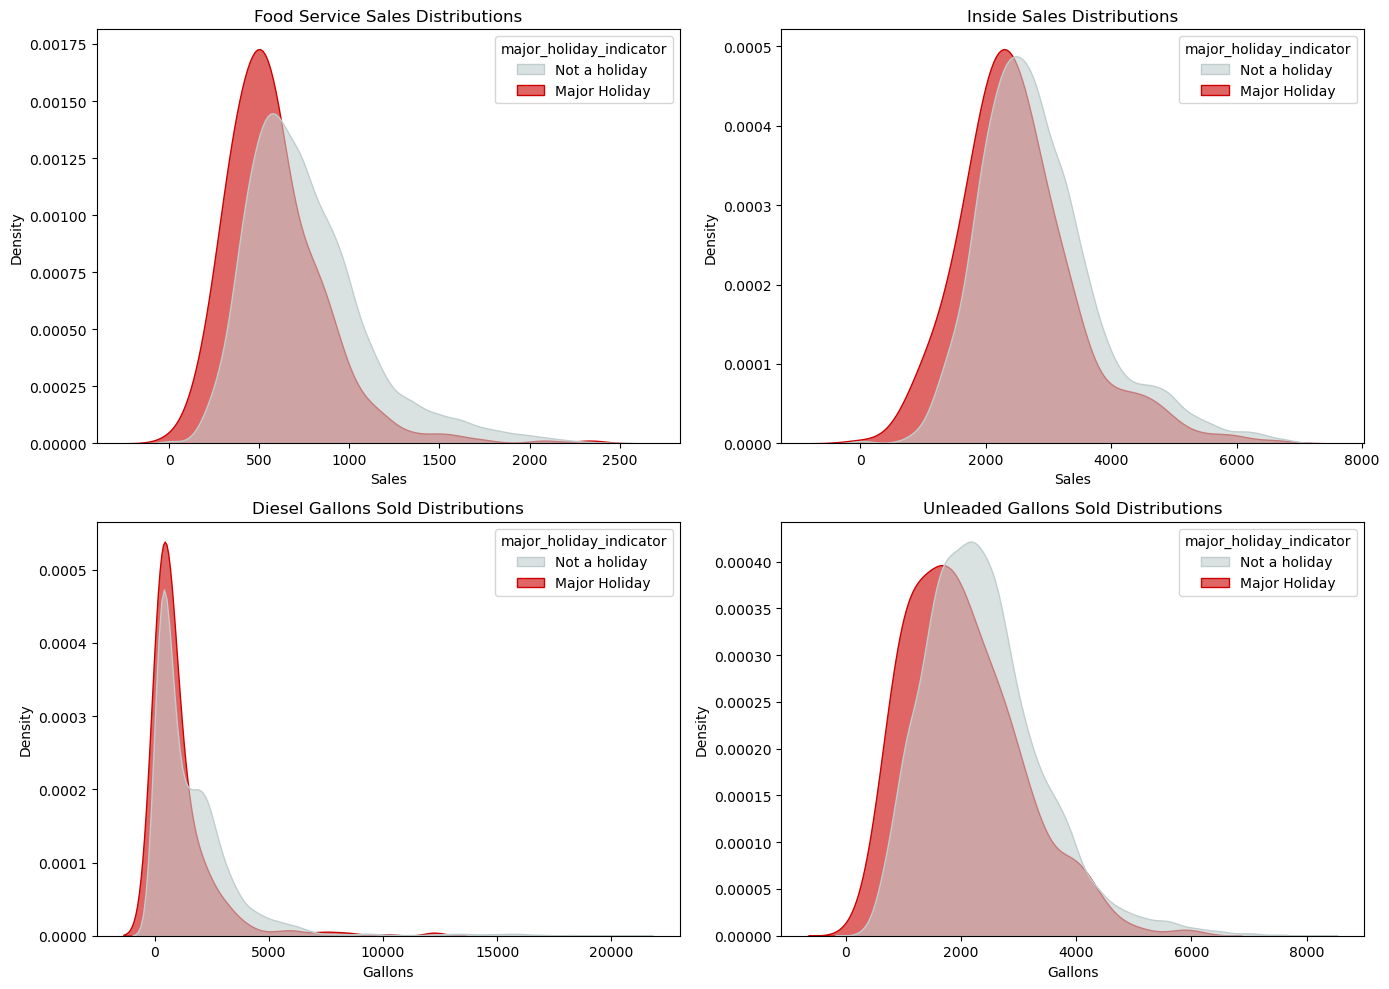

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Convert 'major_holiday_indicator' to a categorical type for proper coloring and legend handling
ts_with_holidays['major_holiday_indicator'] = ts_with_holidays['major_holiday_indicator'].astype('category')

# Define color palette
color_palette = {0: "#C1CDCD", 1: "#CC0000"}
labels = {0: "Not a holiday", 1: "Major Holiday"}

# Create a grid for the plots
fig = plt.figure(figsize=(14, 10))
gs = GridSpec(2, 2, figure=fig)

# Food Service Sales Distribution
ax0 = fig.add_subplot(gs[0, 0])
sns.kdeplot(data=ts_with_holidays, x='daily_yoy_ndt.total_food_service', hue='major_holiday_indicator', fill=True, common_norm=False, palette=color_palette, alpha=0.6, ax=ax0)
ax0.set_title('Food Service Sales Distributions')
ax0.set_xlabel('Sales')

# Inside Sales Distribution
ax1 = fig.add_subplot(gs[0, 1])
sns.kdeplot(data=ts_with_holidays, x='daily_yoy_ndt.total_inside_sales', hue='major_holiday_indicator', fill=True, common_norm=False, palette=color_palette, alpha=0.6, ax=ax1)
ax1.set_title('Inside Sales Distributions')
ax1.set_xlabel('Sales')

# Diesel Gallons Sold Distribution
ax2 = fig.add_subplot(gs[1, 0])
sns.kdeplot(data=ts_with_holidays, x='diesel', hue='major_holiday_indicator', fill=True, common_norm=False, palette=color_palette, alpha=0.6, ax=ax2)
ax2.set_title('Diesel Gallons Sold Distributions')
ax2.set_xlabel('Gallons')

# Unleaded Gallons Sold Distribution
ax3 = fig.add_subplot(gs[1, 1])
sns.kdeplot(data=ts_with_holidays, x='unleaded', hue='major_holiday_indicator', fill=True, common_norm=False, palette=color_palette, alpha=0.6, ax=ax3)
ax3.set_title('Unleaded Gallons Sold Distributions')
ax3.set_xlabel('Gallons')

# Set legend labels
for ax in [ax0, ax1, ax2, ax3]:
    legend = ax.get_legend()
    if legend:
        for t, l in zip(legend.texts, labels.values()):
            t.set_text(l)

# Adjust layout
plt.tight_layout()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


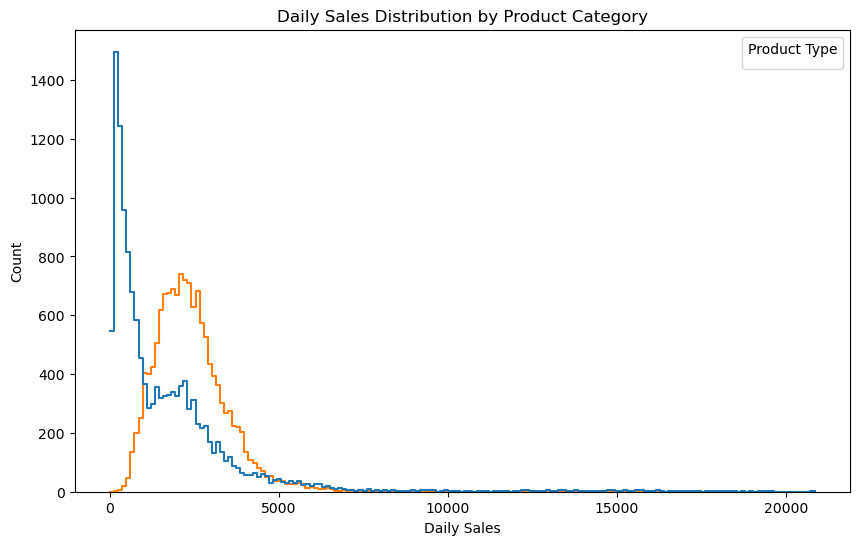

In [13]:
# Step 1: Select the columns for diesel and unleaded sales (assuming raw_ts is already loaded into the environment)
# Step 2: Reshape the DataFrame from wide to long format using pd.melt
fuel_sales_long = pd.melt(raw_ts[['diesel', 'unleaded']], var_name='product_type', value_name='sales')

# Step 3: Create a histogram plot
plt.figure(figsize=(10, 6))
sns.histplot(data=fuel_sales_long, x='sales', hue='product_type', element='step', fill=False, common_bins=True, stat='count')
plt.title('Daily Sales Distribution by Product Category')
plt.xlabel('Daily Sales')
plt.ylabel('Count')
plt.legend(title='Product Type')
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


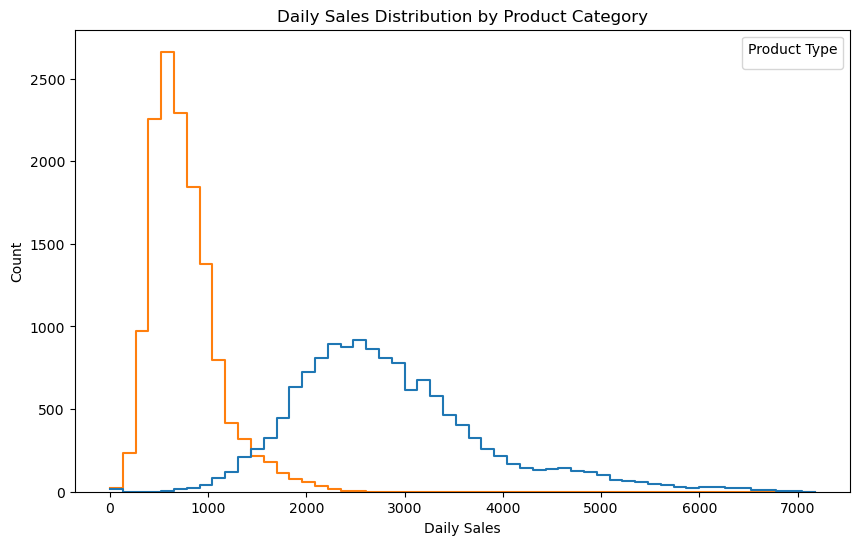

In [14]:
# Assuming 'raw_ts' is the DataFrame 'time_series_data' which we have read earlier.
# First, we'll rename the columns as specified
time_series_data_renamed = time_series_data.rename(columns={
    'daily_yoy_ndt.total_inside_sales': 'inside_sales',
    'daily_yoy_ndt.total_food_service': 'food_sales'
})

# Now, we'll reshape the DataFrame from wide to long format using pd.melt
inside_store_sales_long = pd.melt(time_series_data_renamed[['inside_sales', 'food_sales']], var_name='product_type', value_name='sales')

# Finally, we'll create a histogram plot
plt.figure(figsize=(10, 6))
sns.histplot(data=inside_store_sales_long, x='sales', hue='product_type', element='step', fill=False, common_bins=True, stat='count')
plt.title('Daily Sales Distribution by Product Category')
plt.xlabel('Daily Sales')
plt.ylabel('Count')
plt.legend(title='Product Type')
plt.show()


In [15]:
# Assuming 'qual_data' is a DataFrame that we have already loaded (the qualitative data CSV)
# First, we select the necessary columns
qual_data_subset = qual_data[['square_feet', 'parking_spaces', 'lottery']]

# Then, convert the 'lottery' column to a categorical type
qual_data_subset['lottery'] = qual_data_subset['lottery'].astype('category')

# Finally, we provide a summary of these columns
qual_data_summary = qual_data_subset.describe(include='all')  # 'include=all' to get summary for categorical data as well
qual_data_summary


C:\Users\Garish Prajapat\AppData\Local\Temp\ipykernel_5380\331522372.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qual_data_subset['lottery'] = qual_data_subset['lottery'].astype('category')


,square_feet,parking_spaces,lottery
count,37.00000,37.000000,37
unique,NaN,NaN,2
top,NaN,NaN,Yes
freq,NaN,NaN,23
mean,4970.27027,37.405405,NaN
std,575.93121,5.918237,NaN
min,2933.00000,23.000000,NaN
25%,5046.00000,34.000000,NaN
50%,5046.00000,38.000000,NaN
75%,5046.00000,41.000000,NaN


In [16]:
# Select the necessary columns from the qualitative data
qual_data_subset_2 = qual_data[['freal', 'bonfire_grill', 'pizza', 'cinnabon', 'godfather_s_pizza']]

# Convert all selected columns to a categorical type
qual_data_subset_2 = qual_data_subset_2.astype('category')

# Provide a summary of these categorical columns
qual_data_summary_2 = qual_data_subset_2.describe(include='all')
qual_data_summary_2


,freal,bonfire_grill,pizza,cinnabon,godfather_s_pizza
count,37,37,37,37,37
unique,2,2,2,2,1
top,Yes,Yes,No,No,No
freq,36,26,22,35,37


In [17]:
# Select the necessary columns related to fuel stations from the qualitative data
qual_data_fuel_subset = qual_data[['ethanol_free', 'diesel', 'hi_flow_lanes', 'rv_lanes', 'hi_flow_rv_lanes']]

# Convert all selected columns to a categorical type
qual_data_fuel_subset = qual_data_fuel_subset.astype('category')

# Provide a summary of these categorical columns
qual_data_fuel_summary = qual_data_fuel_subset.describe(include='all')
qual_data_fuel_summary


,ethanol_free,diesel,hi_flow_lanes,rv_lanes,hi_flow_rv_lanes
count,37,37,37,37,37
unique,2,1,2,2,2
top,Yes,Yes,Yes,Yes,Yes
freq,26,37,22,23,22


In [18]:
# Select the necessary columns related to additional fuel station services from the qualitative data
qual_data_services_subset = qual_data[['def', 'cat_scales', 'car_wash', 'ev_charging', 'rv_dumps', 'propane']]

# Convert all selected columns to a categorical type
qual_data_services_subset = qual_data_services_subset.astype('category')

# Provide a summary of these categorical columns
qual_data_services_summary = qual_data_services_subset.describe(include='all')
qual_data_services_summary


,def,cat_scales,car_wash,ev_charging,rv_dumps,propane
count,37,37,37,37,37,37
unique,2,2,1,1,2,2
top,Yes,No,No,No,No,Yes
freq,23,32,37,37,24,31


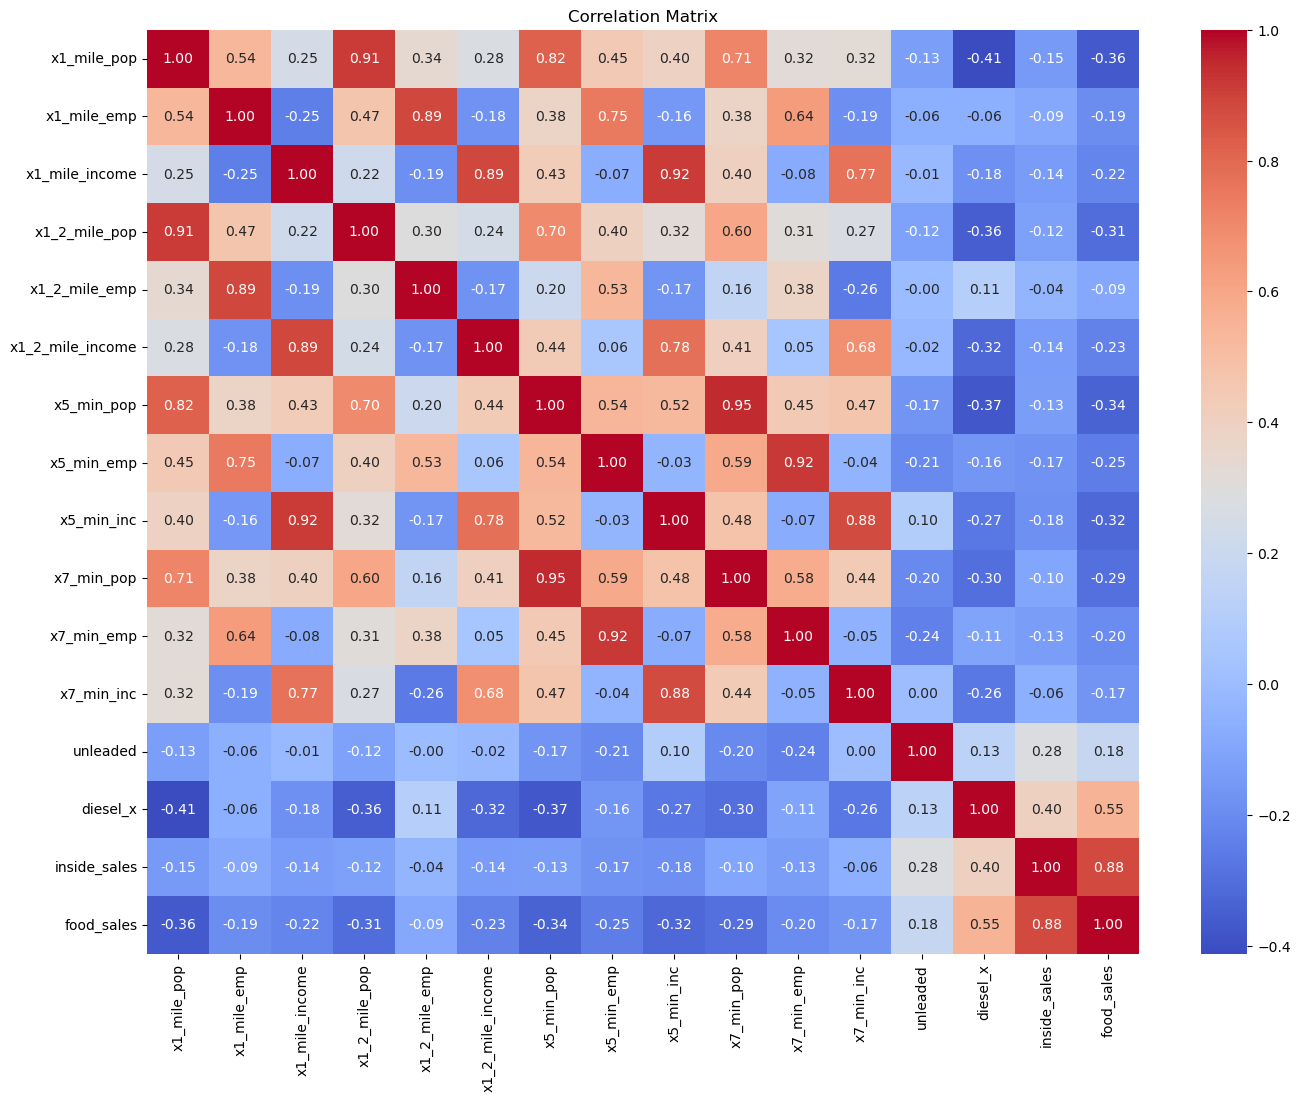

In [19]:
# Load the data (assuming it's stored in the same directory with the correct filenames)
demo_values = pd.read_csv("qualitative_data_msba.csv")
ts_import = pd.read_csv("time_series_data_msba.csv")

# Merge the two dataframes on 'site_id_msba'
demo_values_merged = pd.merge(ts_import, demo_values, on="site_id_msba")

# Select and rename the columns
demo_values_subset = demo_values_merged[[
    "site_id_msba",
    "x1_mile_pop",
    "x1_mile_emp",
    "x1_mile_income",
    "x1_2_mile_pop",
    "x1_2_mile_emp",
    "x1_2_mile_income",
    "x5_min_pop",
    "x5_min_emp",
    "x5_min_inc",
    "x7_min_pop",
    "x7_min_emp",
    "x7_min_inc",
    "unleaded",
    "diesel_x",
    "daily_yoy_ndt.total_inside_sales",
    "daily_yoy_ndt.total_food_service"
]].rename(columns={
    'daily_yoy_ndt.total_inside_sales': 'inside_sales',
    'daily_yoy_ndt.total_food_service': 'food_sales'
})

# Drop the first column 'site_id_msba' for correlation analysis
demo_values_for_correlation = demo_values_subset.drop(columns=['site_id_msba'])

# Calculate the correlation matrix
demo_values_cor = demo_values_for_correlation.corr()

# Plot the correlation matrix using seaborn
plt.figure(figsize=(16, 12))
sns.heatmap(demo_values_cor, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix')
plt.show()




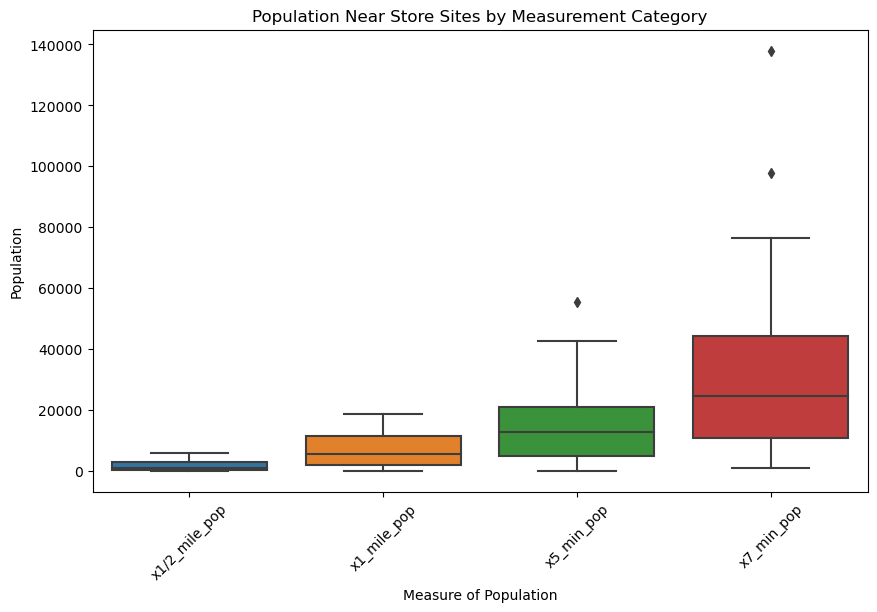

In [20]:
# Select the required columns for the boxplot
qual_data_population = qual_data[['site_id_msba', 'x1_2_mile_pop', 'x1_mile_pop', 'x5_min_pop', 'x7_min_pop']].copy()

# Rename the column for consistency
qual_data_population.rename(columns={'x1_2_mile_pop': 'x1/2_mile_pop'}, inplace=True)

# Melt the dataframe to go from wide to long format, suitable for boxplot
qual_data_population_melted = qual_data_population.melt(id_vars='site_id_msba', var_name='population_measure', value_name='population')

# Convert the 'population_measure' to a categorical type for proper ordering in the boxplot
qual_data_population_melted['population_measure'] = qual_data_population_melted['population_measure'].astype('category')

# Create the boxplot using seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(data=qual_data_population_melted, y='population', x='population_measure')
plt.title("Population Near Store Sites by Measurement Category")
plt.xlabel("Measure of Population")
plt.ylabel("Population")
plt.xticks(rotation=45)
plt.show()


In [21]:
file_path = 'time_series_data_msba.csv'
time_series_data = pd.read_csv(file_path)

time_series_data.head()


,Unnamed: 0,capital_projects.soft_opening_date,calendar.calendar_day_date,calendar.fiscal_week_id_for_year,calendar.day_of_week,calendar_information.holiday,calendar_information.type_of_day,daily_yoy_ndt.total_inside_sales,daily_yoy_ndt.total_food_service,diesel,unleaded,site_id_msba
0,1,2022-06-14,2022-06-17,25,Friday,NONE,WEEKDAY,2168.2920,861.6930,722.7745,1425.1020,24535
1,2,2022-06-14,2022-06-22,25,Wednesday,NONE,WEEKDAY,2051.5635,808.0275,730.4850,1436.2740,24535
2,3,2022-06-14,2022-06-23,25,Thursday,NONE,WEEKDAY,2257.5000,966.4410,895.7970,1594.3725,24535
3,4,2022-06-14,2022-06-26,26,Sunday,NONE,WEEKEND,1520.5925,542.3250,584.2900,1124.9280,24535
4,5,2022-06-14,2022-06-27,26,Monday,NONE,WEEKDAY,1897.6930,771.4525,852.2605,1640.2540,24535


In [23]:
# Convert 'calendar.calendar_day_date' to datetime
time_series_data['calendar.calendar_day_date'] = pd.to_datetime(time_series_data['calendar.calendar_day_date'])

time_series_data_sorted = time_series_data.sort_values('calendar.calendar_day_date')

missing_values = time_series_data_sorted.isnull().sum()

# Drop the 'Unnamed: 0' column as it seems like an index
time_series_data_sorted.drop('Unnamed: 0', axis=1, inplace=True)

time_series_data_sorted.head(), missing_values


(      capital_projects.soft_opening_date calendar.calendar_day_date  \
 13813                         2021-01-12                 2021-01-12   
 13814                         2021-01-12                 2021-01-13   
 13815                         2021-01-12                 2021-01-14   
 13725                         2021-01-12                 2021-01-15   
 13816                         2021-01-12                 2021-01-16   
 
        calendar.fiscal_week_id_for_year calendar.day_of_week  \
 13813                                 2              Tuesday   
 13814                                 2            Wednesday   
 13815                                 2             Thursday   
 13725                                 3               Friday   
 13816                                 3             Saturday   
 
       calendar_information.holiday calendar_information.type_of_day  \
 13813                         NONE                          WEEKDAY   
 13814                        

In [24]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

# One-hot encode the categorical features
categorical_features = ['calendar.day_of_week', 'calendar_information.type_of_day']

# Perform one-hot encoding
onehot_encoder = OneHotEncoder(sparse=False, drop='first')  # Drop first to avoid dummy variable trap
encoded_categorical = onehot_encoder.fit_transform(time_series_data_sorted[categorical_features])

# Get feature names from one-hot encoder
encoded_feature_names = onehot_encoder.get_feature_names_out(categorical_features)

# Convert to DataFrame
encoded_categorical_df = pd.DataFrame(encoded_categorical, columns=encoded_feature_names)

# Drop the original categorical columns and concatenate the one-hot encoded columns
time_series_data_processed = pd.concat([time_series_data_sorted.reset_index(drop=True), encoded_categorical_df.reset_index(drop=True)], axis=1)
time_series_data_processed.drop(categorical_features, axis=1, inplace=True)

# Normalize continuous variables
continuous_features = ['daily_yoy_ndt.total_inside_sales', 'daily_yoy_ndt.total_food_service', 'diesel', 'unleaded']

# Apply MinMaxScaler
scaler = MinMaxScaler()
time_series_data_processed[continuous_features] = scaler.fit_transform(time_series_data_processed[continuous_features])

# Shift the target variable by one month for prediction (assuming the data is daily)
# We will predict 30 days ahead; hence we shift by -30
time_series_data_processed['target'] = time_series_data_processed['daily_yoy_ndt.total_inside_sales'].shift(-30)

# Drop the last 30 rows where the target would be NaN after shifting
time_series_data_processed.dropna(subset=['target'], inplace=True)

# Split the data into features and target
X = time_series_data_processed.drop(['target', 'calendar.calendar_day_date', 'capital_projects.soft_opening_date', 'site_id_msba'], axis=1)
y = time_series_data_processed['target']

# Split the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Checking the shapes of the resulting datasets
(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


D:\Anaconda\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


((11102, 13), (2776, 13), (11102,), (2776,))

Epoch 1/10
25/25 [==============================] - 4s 45ms/step - loss: 0.0447 - val_loss: 0.0211
Epoch 2/10
25/25 [==============================] - 0s 17ms/step - loss: 0.0205 - val_loss: 0.0185
Epoch 3/10
25/25 [==============================] - 0s 17ms/step - loss: 0.0205 - val_loss: 0.0180
Epoch 4/10
25/25 [==============================] - 0s 17ms/step - loss: 0.0204 - val_loss: 0.0183
Epoch 5/10
25/25 [==============================] - 0s 17ms/step - loss: 0.0210 - val_loss: 0.0187
Epoch 6/10
25/25 [==============================] - 0s 17ms/step - loss: 0.0200 - val_loss: 0.0179
Epoch 7/10
25/25 [==============================] - 0s 17ms/step - loss: 0.0206 - val_loss: 0.0179
Epoch 8/10
25/25 [==============================] - 0s 17ms/step - loss: 0.0204 - val_loss: 0.0189
Epoch 9/10
25/25 [==============================] - 0s 17ms/step - loss: 0.0202 - val_loss: 0.0178
Epoch 10/10
1/1 [==============================] - 1s 638ms/step
Mean Squared Error: 0.020839704189218593
Mea

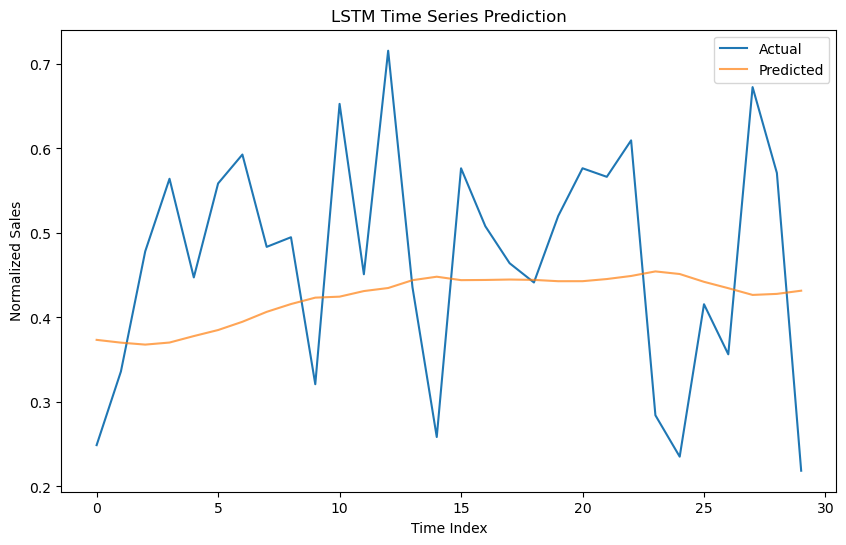

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

data = pd.read_csv('time_series_data_msba.csv')

data['calendar.calendar_day_date'] = pd.to_datetime(data['calendar.calendar_day_date'])
data.sort_values('calendar.calendar_day_date', inplace=True)

# Handle missing values - this will need to be tailored to your dataset
# For example, if missing values are filled with 'NONE', replace with NaN and then fill or drop
data.replace('NONE', np.nan, inplace=True)
data.dropna(inplace=True)  # or you could use data.fillna(method='ffill') to forward-fill

scaler = MinMaxScaler()
data[['daily_yoy_ndt.total_inside_sales']] = scaler.fit_transform(data[['daily_yoy_ndt.total_inside_sales']])

# Prepare the data for LSTM
target = 'daily_yoy_ndt.total_inside_sales'
time_steps = 30  # One month of data; assuming daily frequency

# Function to create sequences
def create_sequences(input_data, target, time_steps):
    Xs, ys = [], []
    for i in range(len(input_data) - time_steps):
        Xs.append(input_data.iloc[i:(i + time_steps)].values)
        ys.append(target.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

# Create sequences
X, y = create_sequences(data[['daily_yoy_ndt.total_inside_sales']], data[target], time_steps)

# Split the data into train and test sets
test_size = 30  # Hold out the last month for testing
X_train, X_test = X[:-test_size], X[-test_size:]
y_train, y_test = y[:-test_size], y[-test_size:]

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1, verbose=1)

# Make predictions
predictions = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared score: {r2}')

# Plot the actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted', alpha=0.7)
plt.title('LSTM Time Series Prediction')
plt.xlabel('Time Index')
plt.ylabel('Normalized Sales')
plt.legend()
plt.show()
